# 

- **Questions**: [Here](../data/homework_3/HW3.pdf)
- **Answer Set** : NO. 03
- **Full Name** : Fatemeh Karimi Barikarasfi
- **Student Code** : 610301060


## Importing Needed Libraries

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPool2D, Dropout, ZeroPadding2D
from tensorflow.keras.models import Model, Sequential

## Loading Data

In [5]:
def generator():
    for file in os.listdir("/gdrive/MyDrive/dataset/dataset"):
        image = cv2.imread(f"/gdrive/MyDrive/dataset/dataset/{file}")
        image = cv2.resize(image, (257 , 257))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        yield (
            tf.convert_to_tensor(image),
            tf.constant([1, 0] if "_0.tif" in file else [0, 1])
        )

dataset = tf.data.Dataset.from_generator(generator, output_signature=(
    tf.TensorSpec(shape=(257, 257, 3), dtype=tf.uint8),
    tf.TensorSpec(shape=(2), dtype=tf.uint8))
)

## Data Augmentation

In [6]:
def nothing(image):
    return image

def rotate90(image):
    return cv2.rotate(image.numpy(), cv2.ROTATE_90_CLOCKWISE)

def rotate180(image):
    return cv2.rotate(image.numpy(), cv2.ROTATE_180)

def rotate270(image):
    return cv2.rotate(image.numpy(), cv2.ROTATE_90_COUNTERCLOCKWISE)

def flipX(image):
    return cv2.flip(image.numpy(), 0)

def flipY(image):
    return cv2.flip(image.numpy(), 1)

def flipXY(image):
    return cv2.flip(image.numpy(), -1)

def equalize(image):
    ycrcb_img = cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2YCrCb)
    ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])
    return cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2RGB)

## Train_Test Spliting

In [7]:
final_dataset = dataset.shuffle(buffer_size=100, seed=313)

total_samples = final_dataset.reduce(0, lambda x, _: x + 1).numpy()
train_size = int(total_samples * 0.8)
test_size = total_samples - train_size

trainset = final_dataset.take(train_size)
testset = final_dataset.skip(train_size)

augmented_trainsets = [
    trainset.map(lambda x, y: (tf.py_function(mapper, [x], (tf.uint8)), y))
    for mapper in [nothing, rotate90, rotate180, rotate270, flipX, flipY, flipXY, equalize]
]


trainset = augmented_trainsets[0]
for ds in augmented_trainsets[1:]:
    trainset = trainset.concatenate(ds)

trainset = trainset.batch(100)
testset = testset.batch(1)

## Model

In [8]:
Model = Sequential([
    Input(shape = (257, 257, 3)),

    # 1
    ZeroPadding2D(padding=(2, 2)),
    Conv2D(48, (3, 3), strides = 2, activation = 'relu'),
    MaxPool2D(pool_size = (2, 2), strides = (2, 2)),

    # 2
    ZeroPadding2D(padding=(2, 2)),
    Conv2D(48, (3, 3), strides = 1, activation = 'relu'),
    MaxPool2D(pool_size = (2, 2), strides = 2),

    # 3
    ZeroPadding2D(padding=(3, 3)),
    Conv2D(48, (5, 5), strides = 1, activation = 'relu'),

    # 4
    ZeroPadding2D(padding=(2, 2)),
    Conv2D(48, (3, 3), strides = 1, activation = 'relu'),

    # 5
    ZeroPadding2D(padding=(2, 2)),
    Conv2D(48, (3, 3), strides = 1, activation = 'relu'),
    MaxPool2D(pool_size = (3, 3), strides = 2),

    # FC
    Flatten(),
    Dense(1000, activation = 'relu'),
    Dropout(0.5),
    Dense(2, activation = 'softmax')
])

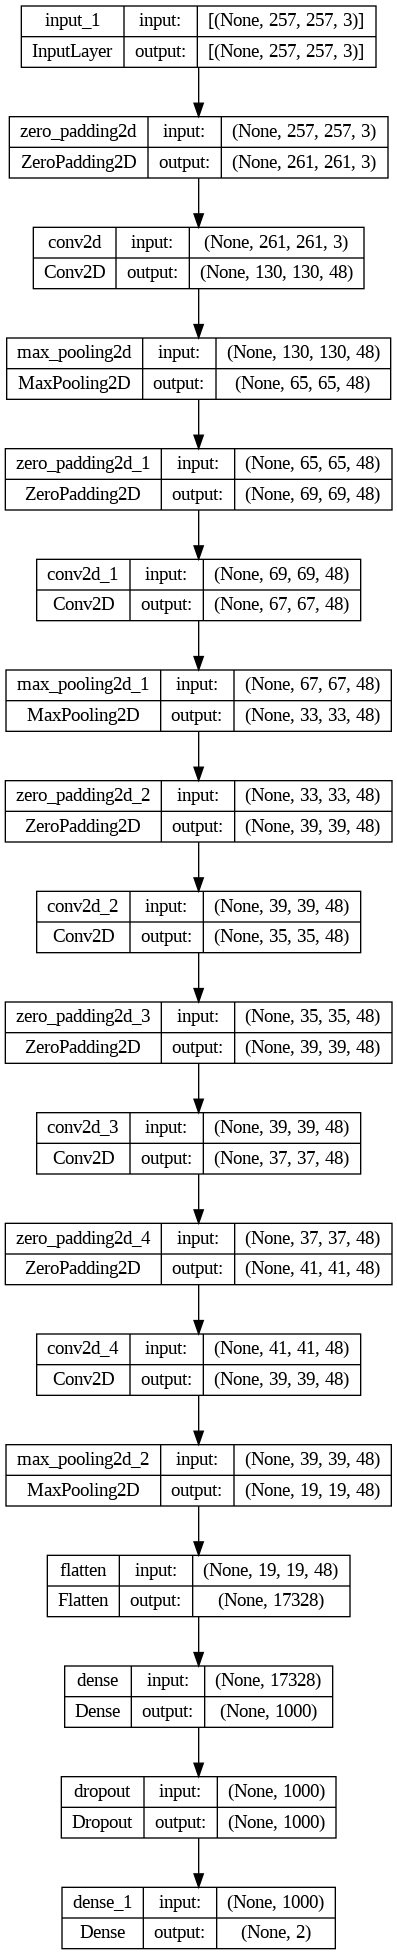

In [9]:
tf.keras.utils.plot_model(Model,
                          show_shapes = True,
                          expand_nested = True)

In [10]:
Model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

hist = Model.fit(trainset, validation_data=testset, epochs = 50)

Epoch 1/50
17/17 [==============================] - 25s 711ms/step - loss: 47.4174 - accuracy: 0.4597 - val_loss: 1.0144 - val_accuracy: 0.6154
Epoch 2/50
17/17 [==============================] - 10s 561ms/step - loss: 5.0215 - accuracy: 0.5294 - val_loss: 11.9198 - val_accuracy: 0.2692
Epoch 3/50
17/17 [==============================] - 10s 592ms/step - loss: 4.1086 - accuracy: 0.5505 - val_loss: 2.4011 - val_accuracy: 0.3462
Epoch 4/50
17/17 [==============================] - 10s 592ms/step - loss: 2.0646 - accuracy: 0.6046 - val_loss: 1.4216 - val_accuracy: 0.5192
Epoch 5/50
17/17 [==============================] - 13s 766ms/step - loss: 1.0751 - accuracy: 0.6502 - val_loss: 0.6133 - val_accuracy: 0.5577
Epoch 6/50
17/17 [==============================] - 11s 596ms/step - loss: 0.6580 - accuracy: 0.7224 - val_loss: 0.7875 - val_accuracy: 0.6154
Epoch 7/50
17/17 [==============================] - 10s 579ms/step - loss: 0.4994 - accuracy: 0.7674 - val_loss: 0.8140 - val_accuracy: 0.53

## Model Evaluation

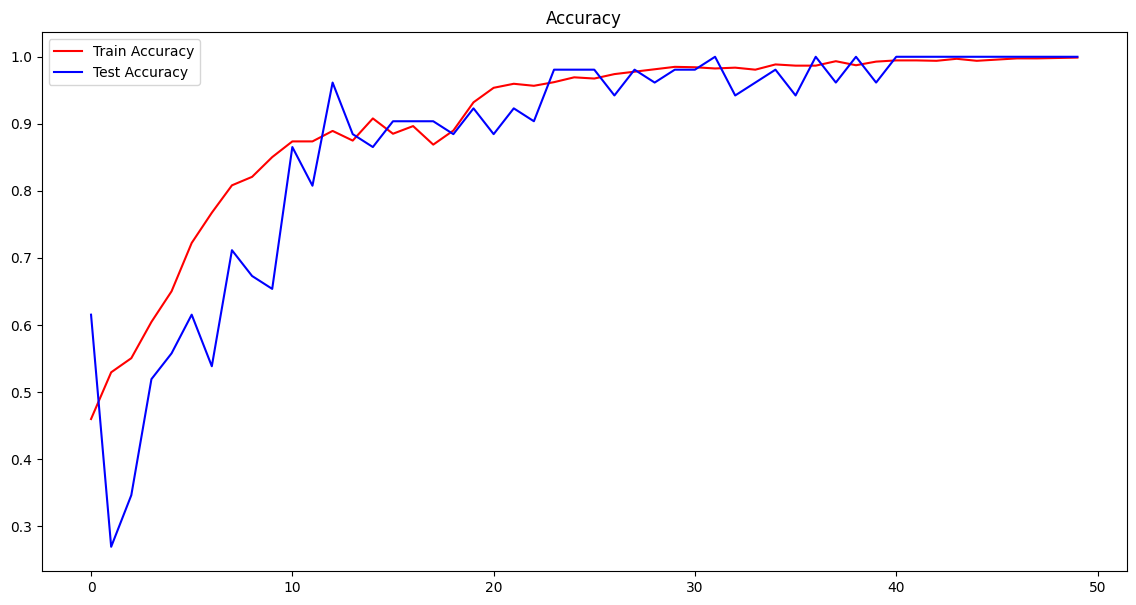

In [11]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

epochs = range(len(acc))
plt.figure(figsize = (14, 7))
plt.title('Accuracy')
plt.plot(epochs, acc, 'r', label = 'Train Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Test Accuracy')
plt.legend(loc = 'upper left')

plt.show()

In [12]:
print(Model.evaluate(testset))

52/52 [==============================] - 1s 5ms/step - loss: 0.0090 - accuracy: 1.0000
[0.008963445201516151, 1.0]


In [13]:
testds = list(testset)

y_true = [y.numpy().argmax(1)[0] for _, y in testds]
y_pred = Model.predict(tf.stack([x[0] for x, _ in testds])).argmax(1)

tf.math.confusion_matrix(labels=y_true, predictions=y_pred)

2/2 [==============================] - 1s 321ms/step


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[13,  0],
       [ 0, 39]], dtype=int32)>

In [14]:
cm = confusion_matrix(y_pred, y_true)

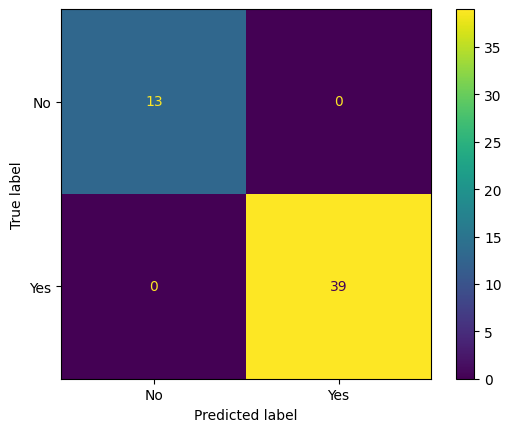

In [15]:
ConfusionMatrixDisplay(cm, display_labels = ['No', 'Yes'], ).plot()
plt.show()

In [16]:
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        39

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52

